# Energy Prediction - Knowledge Transfer in the Form of Model
Another way of knowledge transfer is through model. We train the model on source data and fine tune the trained model using target data. In this notebook, we will explore knowledge transfer from simulated data to the field data in the form of a trained model. 

## Initial Setup

In [1]:
import sys
sys.path.append('../')

In [2]:
import itertools
import numpy as np
import pandas as pd 

from sklearn.base import clone
from sklearn.utils.validation import _num_samples

import matplotlib.pyplot as plt
from transBEAM.utils import data_handler
from transBEAM.models import preprocessor, models, tl

## Data Loading and Preprocessing

#### Step-1: Initiate the Data Handler

In [3]:
# process the data
building_dh = data_handler.TimeSeriesDataHandler()

#### Step-2: Load the Data (Source)
TransBEAM can accept any type of time series data in the pandas DataFrame format. One can easily load the data using pandas DataFrame for next steps.

In [4]:
df = pd.read_csv('./sample_data/sim_data.csv', usecols=['Date', 'Time', 'Temperature', 'Electricity'])
df['Date'] = df['Date'] + '-2020'
df

,Date,Time,Electricity,Temperature
0,01-01-2020,01:00,122.300003,-2.0
1,01-01-2020,02:00,136.695892,-3.0
2,01-01-2020,03:00,144.397583,-3.0
3,01-01-2020,04:00,149.712418,-3.0
4,01-01-2020,05:00,145.835617,-3.0
...,...,...,...,...
8755,12-31-2020,20:00,111.436920,NaN
8756,12-31-2020,21:00,136.245880,NaN
8757,12-31-2020,22:00,136.358841,NaN
8758,12-31-2020,23:00,137.670425,NaN


#### Step-3: Data Preprocessing (Source)
TimeSeriesDataHandler is a class to quickly and easily process the time series data. After data processing, the data can easily be accessed using the function `get_data()`

In [5]:
b_name = 'source'
building_dh.add_data(df, b_name)
building_dh.add_datetime(b_name, dt_cols=['Date', 'Time'], dt_format='%m-%d-%Y %H:%M')
building_dh.add_static_features(b_name)
building_dh.add_shift_cols(b_name, col_names=["Temperature"], shift_by=[1])
building_dh.dropna(b_name)

In [6]:
df_source = building_dh.get_data('source')
df_source.head()

,Date,Time,Electricity,Temperature,DayOfWeek,Weekday,HourOfDay,WorkHour,Month,PrevTemperature
datetime,,,,,,,,,,
2020-01-01 02:00:00,01-01-2020,02:00,136.695892,-3.0,2,1,2,0,1,-2.0
2020-01-01 03:00:00,01-01-2020,03:00,144.397583,-3.0,2,1,3,0,1,-3.0
2020-01-01 04:00:00,01-01-2020,04:00,149.712418,-3.0,2,1,4,0,1,-3.0
2020-01-01 05:00:00,01-01-2020,05:00,145.835617,-3.0,2,1,5,0,1,-3.0
2020-01-01 06:00:00,01-01-2020,06:00,117.948349,2.0,2,1,6,0,1,-3.0


## Data Modeling [Source]
In this section, we will illustrate data modeling with the help of two already implemented models: Random Forest and Feed-Forward Neural Network. Before training the model, it is important that we seperate out features and the target model. In the current model, the library doesn't support sequential models.  

In [7]:
X_cols = ['Temperature', 'DayOfWeek', 'Weekday', 'HourOfDay', 'WorkHour', 'Month', 'PrevTemperature']
y_col = 'Electricity'

all_cols = X_cols + [y_col]

#### Step-4: Split and Normalize the Data

In [8]:
dp = preprocessor.DataPreprocessor()
source_train, source_test = dp.data_split(df_source[all_cols], train_size=0.8)
source_train_norm = dp.normalize_data(source_train)

---------------- Size of Training Data:  0.8 % -------------------------
Size of Training Data:  (6872, 8)
Size of Testing Data:  (1719, 8)


#### Step-5: Train the Model

In [9]:
rf = models.RandomForest()
rf.train(source_train_norm[X_cols], source_train_norm[y_col])

## Model Transfer

#### Step-6: Load the Data (Target)
TransBEAM can accept any type of time series data in the pandas DataFrame format. One can easily load the data using pandas DataFrame for next steps.

In [10]:
df = pd.read_csv('./sample_data/field_data.csv', usecols=['Date', 'Time', 'Temperature', 'Electricity'])
df['Date'] = df['Date'] + '-2020'
df

,Date,Time,Temperature,Electricity
0,01-01-2020,01:00,-2.0,205.28125
1,01-01-2020,02:00,-3.0,197.84375
2,01-01-2020,03:00,-3.0,210.50000
3,01-01-2020,04:00,-3.0,201.25000
4,01-01-2020,05:00,-3.0,209.87500
...,...,...,...,...
8755,12-31-2020,20:00,1.0,79.12500
8756,12-31-2020,21:00,1.0,85.75000
8757,12-31-2020,22:00,1.0,66.09375
8758,12-31-2020,23:00,0.5,76.03125


#### Step-7: Data Preprocessing (Target)
TimeSeriesDataHandler is a class to quickly and easily process the time series data. After data processing, the data can easily be accessed using the function `get_data()`

In [11]:
b_name = 'target'
building_dh.add_data(df, b_name)
building_dh.add_datetime(b_name, dt_cols=['Date', 'Time'], dt_format='%m-%d-%Y %H:%M')
building_dh.add_static_features(b_name)
building_dh.add_shift_cols(b_name, col_names=["Temperature"], shift_by=[1])
building_dh.dropna(b_name)

In [12]:
df_target = building_dh.get_data('target')
df_target.head()

,Date,Time,Temperature,Electricity,DayOfWeek,Weekday,HourOfDay,WorkHour,Month,PrevTemperature
datetime,,,,,,,,,,
2020-01-01 02:00:00,01-01-2020,02:00,-3.0,197.84375,2,1,2,0,1,-2.0
2020-01-01 03:00:00,01-01-2020,03:00,-3.0,210.50000,2,1,3,0,1,-3.0
2020-01-01 04:00:00,01-01-2020,04:00,-3.0,201.25000,2,1,4,0,1,-3.0
2020-01-01 05:00:00,01-01-2020,05:00,-3.0,209.87500,2,1,5,0,1,-3.0
2020-01-01 06:00:00,01-01-2020,06:00,2.0,205.62500,2,1,6,0,1,-3.0


#### Step-8: Split and Normalize the Data [Target]

In [13]:
target_train, target_test = dp.data_split(df_target[all_cols], train_size=0.8)
target_train_norm = dp.normalize_data(target_train)

---------------- Size of Training Data:  0.8 % -------------------------
Size of Training Data:  (7004, 8)
Size of Testing Data:  (1752, 8)


#### Step-9: Retrain the Model [Target]

In [14]:
target_model = rf
target_model.train(target_train_norm[X_cols], target_train_norm[y_col])

#### Step-10: Predict on Test Set [Target]

In [15]:
target_test_norm = dp.normalize_data(target_test)

#### Step-11: Visualize the Predictions [Model Trained on Source]

In [16]:
source_y_pred_test = rf.predict(target_test_norm[X_cols])
df_pred_source = dp.inverse_transform(target_test_norm, source_y_pred_test, y_col)

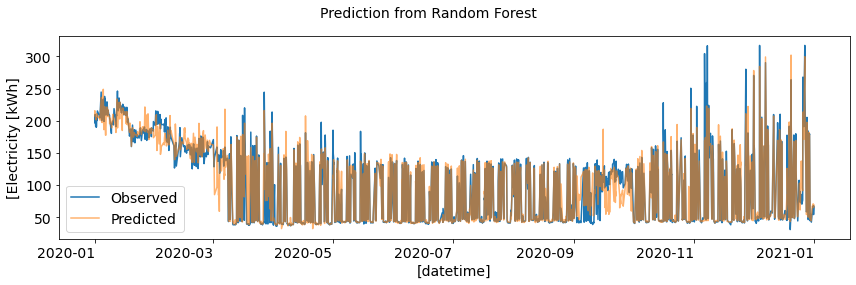

In [17]:
fontsize = 14
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()

target_test["Electricity"].plot(ax=ax, label='Observed', fontsize=fontsize)
df_pred_source["Electricity"].plot(ax=ax, alpha=0.6, label='Predicted', rot=0, fontsize=fontsize)

ax.set_xlabel("[datetime]", fontsize=fontsize)
ax.set_ylabel("[Electricity [kWh]", fontsize=fontsize)
ax.legend(fontsize=fontsize)

fig.suptitle('Prediction from Random Forest', fontsize=fontsize)
fig.tight_layout()

#### Step-12: Visualize the Predictions [Model Trained on Target]

In [18]:
target_y_pred_test = target_model.predict(target_test_norm[X_cols])
df_pred_target = dp.inverse_transform(target_test_norm, target_y_pred_test, y_col)

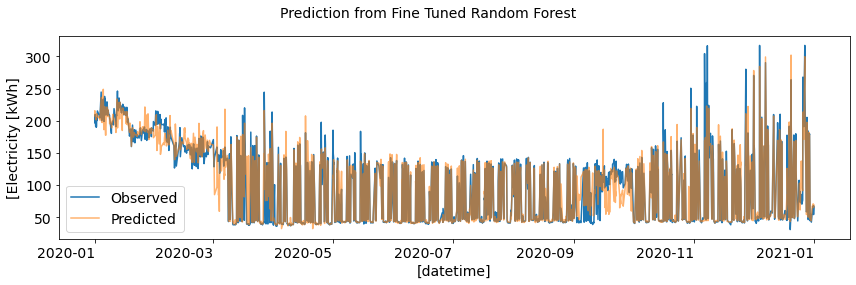

In [19]:
fontsize = 14
fig = plt.figure(figsize=(12, 4))
ax = fig.gca()

target_test["Electricity"].plot(ax=ax, label='Observed', fontsize=fontsize)
df_pred_target["Electricity"].plot(ax=ax, alpha=0.6, label='Predicted', rot=0, fontsize=fontsize)

ax.set_xlabel("[datetime]", fontsize=fontsize)
ax.set_ylabel("[Electricity [kWh]", fontsize=fontsize)
ax.legend(fontsize=fontsize)

fig.suptitle('Prediction from Fine Tuned Random Forest', fontsize=fontsize)
fig.tight_layout()